In [16]:
# import required libraries

import numpy as np
import pandas as pd
import os
import tarfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [17]:


# load dataset and get only 6000 samples from it and store it in a dataframe (pandas)
import os
import tarfile
import random
from PIL import Image

# Path to the .tgz file and extraction directory
tgz_file_path = "C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/lfw-funneled.tgz"
extract_to_path = "C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted"

if not os.path.exists(extract_to_path):  # Extract only if not already extracted
    with tarfile.open(tgz_file_path, 'r:gz') as tar:
        tar.extractall(path=extract_to_path)
        print(f"Extracted to: {extract_to_path}")

# Step 2: Load the data
# Assuming the extracted dataset has subdirectories named after people's names
image_paths = []
labels = []

print(f"Walking through {extract_to_path}...")

for root, dirs, files in os.walk(extract_to_path):
    for file in files:
        if file.endswith(".jpg"):  # Adjust the extension if images have a different format
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # Directory name as the label

# Debug: Check the number of images and labels found
print(f"Total images found: {len(image_paths)}")
print(f"Total labels found: {len(labels)}")

# Ensure labels match the length of image_paths
if len(labels) > len(image_paths):
    labels = labels[:len(image_paths)]

# Debug: Validate alignment of images and labels
assert len(image_paths) == len(labels), "Mismatch between image and label counts!"

# Step 3: Check if there are at least 6000 entries
total_entries = len(image_paths)
print(f"Total entries in dataset: {total_entries}")

if total_entries >= 6000:
    # Randomly sample 6000 indices
    sampled_indices = random.sample(range(total_entries), 6000)

    # Extract the sampled data
    sampled_images = [image_paths[i] for i in sampled_indices]
    sampled_labels = [labels[i] for i in sampled_indices]

    # Optionally load images using PIL with error handling
    images = []
    for img_path in sampled_images:
        try:
            images.append(Image.open(img_path))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

            # Validate lengths of images and labels
    print(f"Length of images: {len(images)}")
    print(f"Length of labels: {len(sampled_labels)}")

    # Ensure images and labels have the same length
    if len(images) == len(sampled_labels):
        # Convert to a pandas DataFrame
        pandas_df = pd.DataFrame({
            'image_paths': sampled_images,
            'name': sampled_labels
        })

        # Check the first few rows of the DataFrame
        print(pandas_df.head())
    else:
        print("Mismatch between number of images and labels after loading.")
else:
    print("Dataset has fewer than 6000 entries.")




Walking through C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted...
Total images found: 13233
Total labels found: 13233
Total entries in dataset: 13233
Length of images: 6000
Length of labels: 6000
                                         image_paths                   name
0  C:/Users/shaik/OneDrive/Desktop/facial_recogni...      Helio_Castroneves
1  C:/Users/shaik/OneDrive/Desktop/facial_recogni...  Dominique_de_Villepin
2  C:/Users/shaik/OneDrive/Desktop/facial_recogni...          Rulon_Gardner
3  C:/Users/shaik/OneDrive/Desktop/facial_recogni...              John_Snow
4  C:/Users/shaik/OneDrive/Desktop/facial_recogni...         Janine_Pietsch


In [18]:
# perform exploratory data analysis on the dataset
pandas_df.head()

,image_paths,name
0,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,Helio_Castroneves
1,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,Dominique_de_Villepin
2,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,Rulon_Gardner
3,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,John_Snow
4,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,Janine_Pietsch


In [19]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_paths  6000 non-null   object
 1   name         6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [20]:
# statistics of the dataset
pandas_df.describe()

,image_paths,name
count,6000,6000
unique,6000,3213
top,C:/Users/shaik/OneDrive/Desktop/facial_recogni...,George_W_Bush
freq,1,252


In [21]:
# check the size of dataframe
print(f"Length of images: {len(pandas_df['image_paths'])}")
print(f"Length of labels: {len(pandas_df['name'])}")

Length of images: 6000
Length of labels: 6000


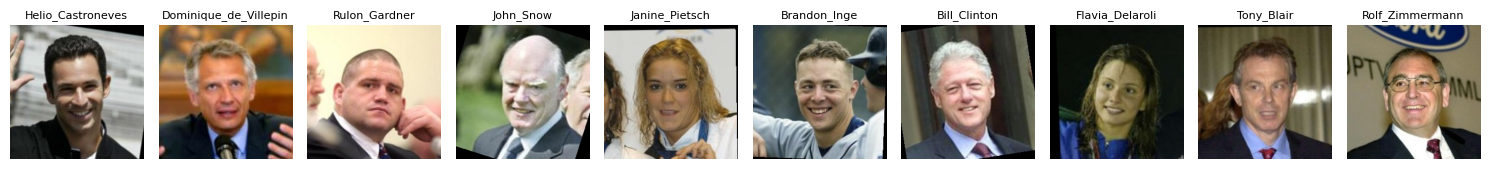

In [22]:
# visualizing sample data to understand what the data looks like

import matplotlib.pyplot as plt
from PIL import Image


# Extract the first 10 image paths and names
num_images = 10
image_paths = pandas_df['image_paths'][:num_images].tolist()
names = pandas_df['name'][:num_images].tolist()

# create a figure with a grid layout
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# loop through the first 10 images and their corresponding axes
for i, ax in enumerate(axes):
    # load the image
    img = Image.open(image_paths[i])
    # display the image
    ax.imshow(img)
    ax.set_title(names[i], fontsize=8)
    ax.axis('off')

# adjust layout for better spacing
plt.tight_layout()
plt.show()


C:\Users\shaik\AppData\Local\Temp\ipykernel_6896\3698710950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=name_df,


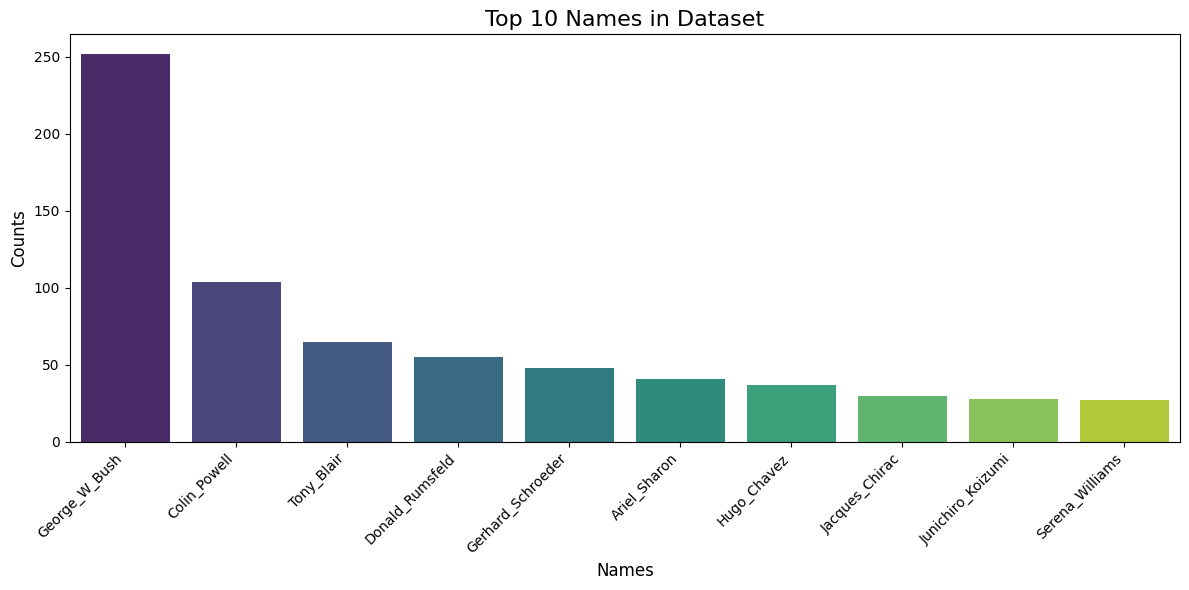

In [23]:
# extracting the top 10 names shown in the dataset

import seaborn as sns
import matplotlib.pyplot as plt



# Creating a Pandas DataFrame (if not directly extracting names)
name_df = pd.DataFrame({"name": pandas_df['name']})

# plotting the top 10 names using seaborn
plt.figure(figsize=(12, 6))
sns.countplot(data=name_df,
              x="name",
              order=name_df['name'].value_counts().iloc[:10].index,
              palette="viridis")

# customizing the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Top 10 Names in Dataset", fontsize=16)
plt.xlabel("Names", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.tight_layout()

# display the plot
plt.show()


In [24]:
# Image Preprocessing Function
def preprocess_images(image_paths, target_size=(224, 224)):
    processed_images = []
    
    # Define augmentation pipeline
    transform = A.Compose([
        # Normalization and resizing
        A.Resize(height=target_size[0], width=target_size[1]),
        
        # Color space augmentations
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
        ], p=0.3),
        
        # Geometric augmentations
        A.OneOf([
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Affine(shear=[-10, 10], p=0.3),
        ], p=0.3),
        
        # Additional preprocessing
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for image_path in image_paths:
        try:
            # Read image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Face detection and alignment (optional)
            face = detect_and_align_face(img)
            if face is None:
                continue  # Skip if no face detected
            
            # Apply augmentation
            augmented = transform(image=face)
            processed_image = augmented['image']
            
            processed_images.append(processed_image)
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    return np.array(processed_images)

def detect_and_align_face(image):
    """
    Detect and align face using OpenCV's Haar Cascade
    """
    # Load pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None
    
    # Take the largest face
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
    
    # Extract face
    face = image[y:y+h, x:x+w]
    
    return face

# Preprocessing
X = preprocess_images(pandas_df['image_paths'])

In [70]:
import pandas as pd

def preprocess_and_store(image_paths):
    processed_images = []
    valid_image_names = []
    names = []  # To store the names of images

    # Preprocess images and keep track of successful ones
    for image_path in image_paths:
        try:
            # Call preprocess_images function for a single image
            img = preprocess_images([image_path])[0]  # Access the single processed image
            
            # Append successful results
            processed_images.append(img)
            valid_image_names.append(image_path)  # Keep full image path
            names.append(image_path.split('/')[-1])  # Extract only the image name
        
        except Exception as e:
            print(f"Skipping {image_path} due to error: {e}")
    
    # Create DataFrame only with successfully processed images
    output_df = pd.DataFrame({
        'processed_image': processed_images,
        'image': valid_image_names,  # Full paths
        'name': names                # Image names
    })
    
    return output_df

# Example usage
df = preprocess_and_store(pandas_df['image_paths'])  # Replace `pandas_df['image_paths']` with the correct column

# Display the resulting DataFrame
print(df.head())

# Save to CSV (without index)
df.to_csv('preprocessed2.csv', index=False)


Skipping C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted\lfw_funneled\Serena_Williams\Serena_Williams_0004.jpg due to error: index 0 is out of bounds for axis 0 with size 0
Skipping C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted\lfw_funneled\Thomas_Birmingham\Thomas_Birmingham_0002.jpg due to error: index 0 is out of bounds for axis 0 with size 0
Skipping C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted\lfw_funneled\Yuvraj_Singh\Yuvraj_Singh_0001.jpg due to error: index 0 is out of bounds for axis 0 with size 0
Skipping C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted\lfw_funneled\John_Bolton\John_Bolton_0016.jpg due to error: index 0 is out of bounds for axis 0 with size 0
Skipping C:/Users/shaik/OneDrive/Desktop/facial_recognition/lfw_dataset/extracted\lfw_funneled\Lindsay_Davenport\Lindsay_Davenport_0015.jpg due to error: index 0 is out of bounds for axis 0 with size 0
Skipping C:/User

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5963 non-null   object
 1   name    5963 non-null   object
dtypes: object(2)
memory usage: 93.3+ KB


In [67]:
df.head()

,image,name
0,[[[-0.3369296 -0.14495796 0.06047932]\n [-0...,extracted\lfw_funneled\Helio_Castroneves\Helio...
1,[[[ 0.12543876 -0.05742294 -0.09638342]\n [ 0...,extracted\lfw_funneled\Dominique_de_Villepin\D...
2,[[[ 1.152924 1.0980392 0.6530719 ]\n [ 0...,extracted\lfw_funneled\Rulon_Gardner\Rulon_Gar...
3,[[[-0.7136741 -0.35504198 -0.82840955]\n [-0...,extracted\lfw_funneled\John_Snow\John_Snow_000...
4,[[[ 1.4440448 1.6232492 1.7336819 ]\n [ 1...,extracted\lfw_funneled\Janine_Pietsch\Janine_P...


In [33]:
# # storing preprocessed data into a dataframe

# def store(image_paths):
#     # Extract image names from the paths
#     image_names = [path.split('/')[-1] for path in image_paths]
    
#     # Ensure X and image_names are aligned
#     if len(X) != len(image_names):
#         print("Warning: Some images were skipped due to errors or no face detection.")
#         image_names = image_names[:len(X)]  # Adjust to match X length
    
#     # Create a DataFrame
#     output_df = pd.DataFrame({
#         'image': list(X),
#         'name': image_names
    
#     })
    
#     return output_df

# # Example usage
# df = store(pandas_df['image_paths'])

# # Display the DataFrame
# print(df.head())


# # Save the processed DataFrame as CSV, 'image' column will be in numpy array format
# df.to_csv('preprocessed.csv', index=False)  # index=False to avoid saving the index as a column

In [50]:

# Prepare labels
unique_labels = np.unique(df['name'])
label_map = {label: index for index, label in enumerate(unique_labels)}
y = np.array([label_map[label] for label in df['name']])

# One-hot encode labels
y_one_hot = to_categorical(y, num_classes=len(unique_labels))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1632845].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7731091..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5185375..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..1.7336819].


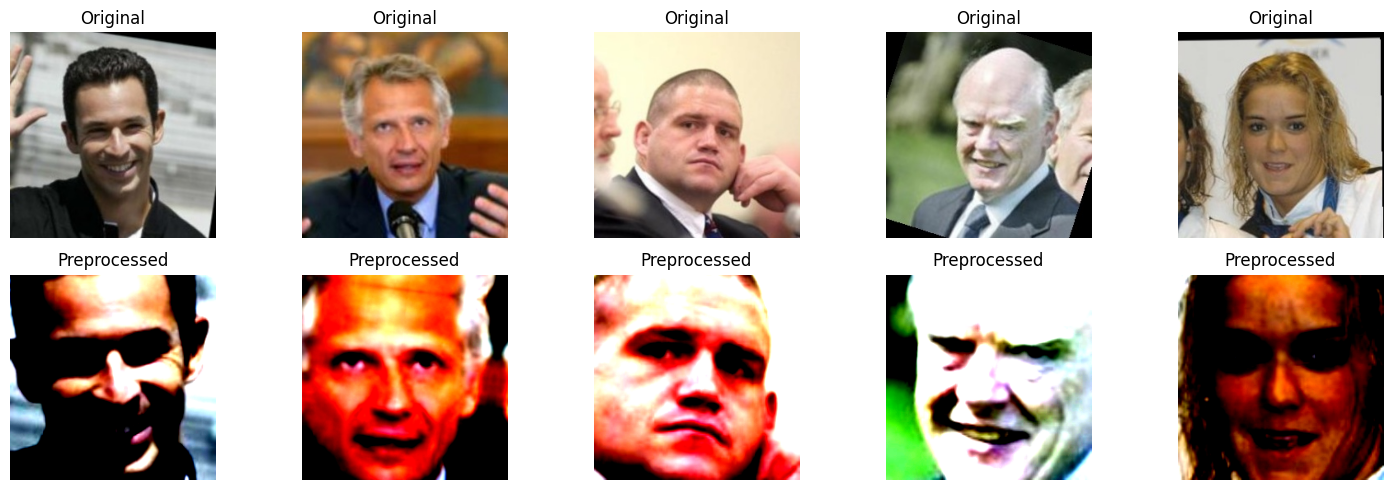

In [51]:
# Visualization of preprocessing results
def visualize_preprocessing(original_paths, processed_images):
    plt.figure(figsize=(15, 5))
    
    for i in range(min(5, len(processed_images))):
        # Original image
        plt.subplot(2, 5, i+1)
        orig_img = Image.open(original_paths[i])
        plt.imshow(orig_img)
        plt.title('Original')
        plt.axis('off')
        
        # Preprocessed image
        plt.subplot(2, 5, i+6)
        plt.imshow(processed_images[i])
        plt.title('Preprocessed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize preprocessing
visualize_preprocessing(pandas_df['image_paths'], df['image'])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5963 non-null   object
 1   name    5963 non-null   object
dtypes: object(2)
memory usage: 93.3+ KB


In [62]:
df['image'] = df['image'].astype(str)


In [65]:
import os

# Verify if all file paths are valid
invalid_paths = df[~df['image'].apply(os.path.exists)]
if not invalid_paths.empty:
    print("Invalid paths found:", invalid_paths)


Invalid paths found:                                                   image  \
0     [[[-0.3369296  -0.14495796  0.06047932]\n  [-0...   
1     [[[ 0.12543876 -0.05742294 -0.09638342]\n  [ 0...   
2     [[[ 1.152924    1.0980392   0.6530719 ]\n  [ 0...   
3     [[[-0.7136741  -0.35504198 -0.82840955]\n  [-0...   
4     [[[ 1.4440448   1.6232492   1.7336819 ]\n  [ 1...   
...                                                 ...   
5958  [[[-1.9295317  -1.9306722  -1.7521569 ]\n  [-1...   
5959  [[[-1.6555356  -1.4754901  -1.3861437 ]\n  [-1...   
5960  [[[-1.004795   -1.0903361  -1.1944226 ]\n  [-1...   
5961  [[[-1.141793   -0.86274505 -0.86326796]\n  [-1...   
5962  [[[-0.7136741  -1.265406   -0.8981263 ]\n  [-0...   

                                                   name  
0     extracted\lfw_funneled\Helio_Castroneves\Helio...  
1     extracted\lfw_funneled\Dominique_de_Villepin\D...  
2     extracted\lfw_funneled\Rulon_Gardner\Rulon_Gar...  
3     extracted\lfw_funneled\John_Snow

In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['image'], y_one_hot, random_state=42, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

# Data generator for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',         # Column with image file paths
    y_col='name',          # Column with labels
    target_size=(128, 128),  # Resize images to (128x128)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training',        # Use training subset
    shuffle=True
)


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='name',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',     # Use validation subset
    shuffle=False
)
print("data loading & augmentation done")

(4770,)
(1193,)
(4770, 5963)
(1193, 5963)
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
data loading & augmentation done


C:\Users\shaik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 5963 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\shaik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 5963 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [64]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load MobileNet pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last 4 layers of the base model for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(X_train), activation='softmax')
])

# Compile the model with SGD and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save('/models/finetuned.h5')
print("Model trained and saved.")


C:\Users\shaik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [47]:
# # Create the transfer learning model
# def create_transfer_learning_model(num_classes):
#     # Load pre-trained MobileNetV2 model
#     base_model = MobileNetV2(
#         weights='imagenet',  # Use pre-trained ImageNet weights
#         include_top=False,   # Remove the original classification layer
#         input_shape=(224, 224, 3)  # Match your image size
#     )

#     # Freeze the base model layers
#     base_model.trainable = False

#     # Add custom classification layers
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     output = Dense(num_classes, activation='softmax')(x)

#     # Create the final model
#     model = Model(inputs=base_model.input, outputs=output)


#     # Compile the model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [ ]:
# # Create the model
# model = create_transfer_learning_model(len(unique_labels))

# # Print model summary
# model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,972,875 (22.78 MB)

 Trainable params: 3,714,891 (14.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
# # Callbacks
# model_name = 'transfer_learning_face_recognition'
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor='val_loss', 
#     patience=3,
#     verbose=1,
#     factor=0.5
# )

# model_checkpoint = ModelCheckpoint(
#     f'models/{model_name}.keras', 
#     monitor='val_accuracy', 
#     save_best_only=True, 
#     mode='max'
# )

# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=5,
#     restore_best_weights=True
# )

In [ ]:
# # Train the model
# history = model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=32),
#     epochs=30,
#     validation_data=validation_datagen.flow(X_test, y_test),
#     callbacks=[learning_rate_reduction, model_checkpoint, early_stopping]
# )

ValueError: setting an array element with a sequence.

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()